# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [17]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [18]:
"""def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)"""

"def download_file(url, file_path):\n    import requests\n    r = requests.get(url)\n    with open(file_path, 'wb') as f:\n        f.write(r.content)\n\ndef load_dataset(file_path, fraction=1.0):\n    with open(file_path, 'r', encoding='utf-8') as f:\n        raw_text = f.read()\n    return raw_text[:int(fraction * len(raw_text))]\n\ndataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt\n\ndownload_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)\n\n# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.\ntext = load_dataset(dataset, fraction=0.1)"

In [19]:
!wget -O shakespeare.txt "https://raw.githubusercontent.com/ShayanHodai/deep_learning/refs/heads/assignment-2/02_activities/assignments/downloaded_books/shakespeare.txt"

--2024-12-02 04:50:20--  https://raw.githubusercontent.com/ShayanHodai/deep_learning/refs/heads/assignment-2/02_activities/assignments/downloaded_books/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9732272 (9.3M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   9.28M  --.-KB/s    in 0.08s   

2024-12-02 04:50:21 (121 MB/s) - ‘shakespeare.txt’ saved [9732272/9732272]



# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [45]:
fraction = 0.03 # fraction of the file to load
file_size = None  # total size in characters (initialize to None)

with open('shakespeare.txt', 'r', encoding='utf-8') as file:
    file_size = len(file.read())  # Get total size
    file.seek(0)  # Reset file pointer
    text = file.read(int(file_size * fraction))

In [21]:
text[:1000]

"The Project Gutenberg EBook of Hamlet, by William Shakespeare\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\nTitle: Hamlet\n\nAuthor: William Shakespeare\n\nEditor: Charles Kean\n\nRelease Date: January 10, 2009 [EBook #27761]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***\n\n\n\n\nProduced by David Starner, Curtis Weyant and the Online\nDistributed Proofreading Team at https://www.pgdp.net\n\n\n\n\n\n\n\n\n\n    Transcriber's Note:\n    This is a heavily edited version of _Hamlet_. It was used\n    for Charles Kean's 1859 stage production. Phrases printed\n    in italics in the book are indicated in this electronic\n    version by _ (underscore). Footnotes originally appeared\n    at the bottom of each page. For 

In [22]:
# dataset's size
dataset_size = len(text)
print(f"\nDataset size: {dataset_size} characters")



Dataset size: 280765 characters


In [23]:
# number of unique characters
unique_characters = set(text)
num_unique_characters = len(unique_characters)
print(f"Number of unique characters: {num_unique_characters}")


Number of unique characters: 104


## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:


*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# convert text to lowercase
text = text.lower()

# vocabulary size and out-of-vocabulary token
VOCAB_SIZE = 10000
OOV_TOKEN = "<OOV>"  # token for out-of-vocabulary words

# initialize the Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# fit the tokenizer on the text
tokenizer.fit_on_texts([text])

# convert the text to sequences
sequences = tokenizer.texts_to_sequences([text])

# check the tokenized output
print("Sample of sequences:", sequences[0][:20])  # first 20 tokens as a sample


Sample of sequences: [2, 70, 68, 360, 4, 55, 30, 538, 270, 15, 360, 13, 19, 2, 160, 4, 867, 1524, 47, 32]


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [25]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('i', 6), ('a', 7), ('you', 8), ('in', 9), ('my', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [26]:
SEQ_LENGTH = 25 # choose an appropriate sequence length

# convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# generate the training sequences
X = []
y = []

for i in range(SEQ_LENGTH, len(sequences)):
    # extract the input sequence of `SEQ_LENGTH` tokens
    input_sequence = sequences[i-SEQ_LENGTH:i]
    # extract the target token (next word)
    target_token = sequences[i]

    X.append(input_sequence)
    y.append(target_token)

# convert to NumPy arrays for better compatibility with Keras
import numpy as np
X = np.array(X)
y = np.array(y)

print("Number of training sequences:", len(X))

Number of training sequences: 45819


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [27]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [   2   70   68  360    4   55   30  538  270   15  360   13   19    2
  160    4  867 1524   47   32 1003    3   17  398   32]
Target: 1525
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no'] -> restrictions


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [28]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (36655, 25)
y_train shape: (36655, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define constants for embedding and LSTM
EMBEDDING_DIM = 100  # Size of the dense representation
LSTM_UNITS = 256     # Number of units in the LSTM layer

model = Sequential([
    # Embedding layer to learn dense representation of input tokens
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LENGTH),

    # LSTM layer for sequence learning
    LSTM(LSTM_UNITS, return_sequences=False),

    # Dense layer with softmax activation for prediction
    Dense(VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

Loss Function: categorical_crossentropy -> This is the standard loss function for multi-class classification problems.
Optimizer: adam -> Efficient and adaptive learning rate adjustment, which is particularly useful for training deep neural networks.
Metric: accuracy ->  Monitor training progress and detect overfitting or underfitting.



In [30]:
# Compile the model
model.compile(
    optimizer='adam',                # Optimizer for efficient training
    loss='categorical_crossentropy', # Loss function for multi-class classification
    metrics=['accuracy']             # Additional metric for performance tracking
)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [31]:
# Train the model
history = model.fit(
    X_train, y_train,              # Training data and labels
    validation_data=(X_val, y_val),# Validation data and labels
    epochs=5,                      # Number of epochs
    batch_size=128                 # Batch size
)


Epoch 1/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0347 - loss: 7.6533 - val_accuracy: 0.0512 - val_loss: 7.0160
Epoch 2/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0395 - loss: 7.1232 - val_accuracy: 0.0534 - val_loss: 7.0550
Epoch 3/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0485 - loss: 6.6060 - val_accuracy: 0.0574 - val_loss: 7.0124
Epoch 4/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0541 - loss: 6.4578 - val_accuracy: 0.0589 - val_loss: 6.9505
Epoch 5/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0640 - loss: 6.2489 - val_accuracy: 0.0692 - val_loss: 6.9083


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

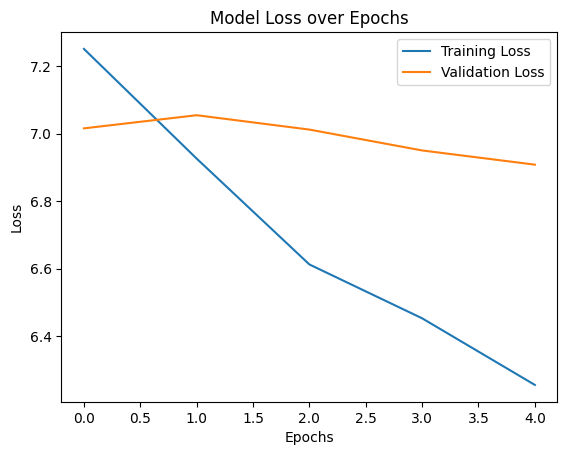

In [32]:
import matplotlib.pyplot as plt


# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [33]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function adds some randomness (temperature) to the prediction
    to make the text more interesting.
    """
    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Sample the token from the probability distribution
    # np.random.choice will randomly pick a word based on the predicted probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.

    Parameters:
    - model: The trained RNN model.
    - tokenizer: The tokenizer used to pre-process the text data.
    - seed_text: The seed text the model will use to generate new text.
    - max_sequence_len: The maximum length of the sequence used to generate new text.
    - num_words: The number of words to generate.

    Returns:
    - The generated text as a string.
    """
    # step 1: tokenize the seed text
    sequence = tokenizer.texts_to_sequences([seed_text])[0]

    # step 2: pad the sequence to match the input shape of the model
    sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding='pre')

    # initialize the generated text with the seed text
    generated_text = seed_text

    # step 3: generate new words until the desired length is reached
    for _ in range(num_words):
        # Get the next predicted word
        predicted_word_id = get_predicted_word(model, sequence)

        # convert the predicted word index back to a word
        predicted_word = tokenizer.index_word.get(predicted_word_id, '')

        # sppend the predicted word to the generated text
        generated_text += ' ' + predicted_word

        # update the sequence by removing the first token and adding the predicted word
        sequence = np.append(sequence[0][1:], predicted_word_id)
        sequence = sequence.reshape(1, -1)

    return generated_text


In [34]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet twelve parre do to god persuaded as will representation yourself mad c you you forget them manacle this 140 i his life as ghost pol a then of this lord in him up the only best rushes as do himself up accessible or nunnery son you and see thou hides'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [35]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-02 04:55:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.95MB/s    in 2m 39s  

2024-12-02 04:57:48 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [36]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [37]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [38]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [40]:
# Define a new model and train it

from keras.layers import Dropout

# Define the new model with GloVe embeddings
model = Sequential([
    # Embedding layer using pre-trained GloVe embeddings
    Embedding(input_dim=VOCAB_SIZE,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],  # Use the embedding matrix we created
              input_length=SEQ_LENGTH,
              trainable=False),  # We won't train the embeddings (they're already pre-trained)

    # Add an LSTM layer
    LSTM(units=128, return_sequences=True),  # Increase the number of units
    Dropout(0.2),  # Add dropout to reduce overfitting

    # Add a second LSTM layer
    LSTM(units=128),  # Another LSTM layer
    Dropout(0.2),

    # Dense layer for prediction
    Dense(units=VOCAB_SIZE, activation='softmax')  # Softmax for multi-class classification
])

In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [42]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,  # Increase the number of epochs to allow more training
                    batch_size=128,  # You can experiment with smaller or larger batch sizes
                    validation_data=(X_val, y_val))


Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.0302 - loss: 7.6181 - val_accuracy: 0.0433 - val_loss: 7.0127
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0394 - loss: 6.8294 - val_accuracy: 0.0433 - val_loss: 7.0478
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0396 - loss: 6.7599 - val_accuracy: 0.0536 - val_loss: 7.0197
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0486 - loss: 6.6834 - val_accuracy: 0.0595 - val_loss: 6.9361
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0553 - loss: 6.5112 - val_accuracy: 0.0632 - val_loss: 6.8516
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0619 - loss: 6.3428 - val_accuracy: 0.0730 - val_loss: 6.7844
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.0689 - loss: 6.2125 - val_accuracy: 0.0751 - val_loss: 6.7364
Epoch 8/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.0731 - loss: 6.0917 - val_acc

In [43]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0815 - loss: 6.7171
Validation Loss: 6.685041904449463
Validation Accuracy: 0.08478830009698868


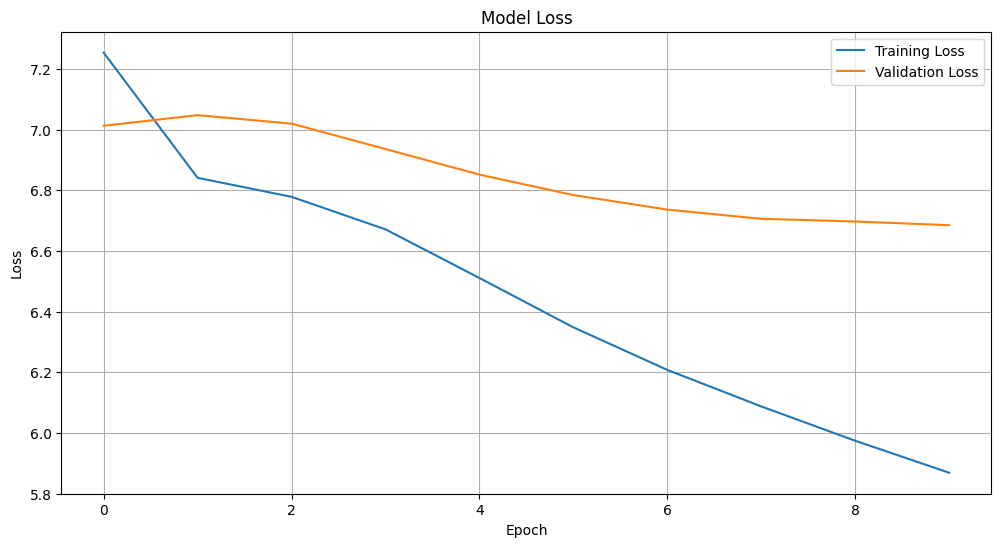

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.